# 15wk-1: 강화학습 (4) – LunarLander

최규빈  
2024-06-10

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/15wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [2]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-zBEizLbjgRE8qMfsJML6Ua&si=HALKE6fjiWB12AGW >}}

# 2. Imports

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
import collections
import IPython

# 3. 예비학습

`-` `collections.deque` 의 기능

In [4]:
a = collections.deque([1,2,3], maxlen = 5 )
a

In [5]:
a.append(4)
a

In [6]:
a.append(5)
a

In [7]:
a.append(6)
a

`-` 단점? numpy array 보다는 list 느낌임 (연산에 특화된건 아님)

In [8]:
a + 1

`-` 그렇지만 필요하다면 np.array 화 시킬 수 있음.

In [9]:
np.array(a) + 1

`-` collection.deque 는 리플레이 버퍼를 구현할때 유용한 자료구조이다.

-   (우리가 했던) 기존방식: 모든 데이터를 저장하며 하나의 경험씩 학습함
-   리플레이버퍼: 최근 $N$개의 데이터를 저장하여 여러경험을 샘플링하여
    학습하는 방식
-   리플레이버퍼의 장점: 메모리를 아낄 수 있다, 다양한 종류의 경험을
    저장하고 무작위로 재사용하여 학습이 안정적으로 된다, “저장 -\> 학습
    -\> 저장” 순으로 반드시 실시간으로 학습할 필요가 없어서 병렬처리에
    용이하다, 강화학습에서 연속된 경험은 상관관계가 있을 수 있는데
    무작위 샘플로 이러한 상관관계를 제거할 수 있음

# 4. LunarLander

`-` 환경생성

In [10]:
env = gym.make('LunarLander-v2', render_mode = 'rgb_array') 
env 

`-` state_space

In [11]:
env.observation_space

`-` action_space

In [12]:
env.action_space

`-` env.reset()

In [13]:
state, _ = env.reset()
state 

`-` env.render()

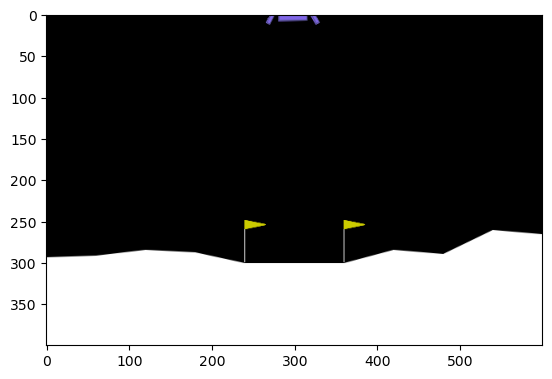

In [14]:
plt.imshow(env.render())

`-` env.step

In [15]:
next_state, reward, terminated, _, _ = env.step(0)
next_state, reward, terminated

`-` play

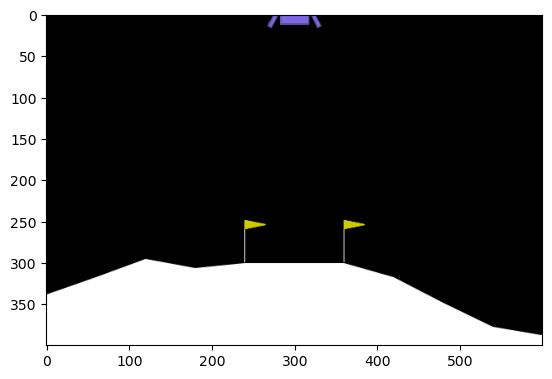

In [16]:
env.reset()
plt.imshow(env.render())

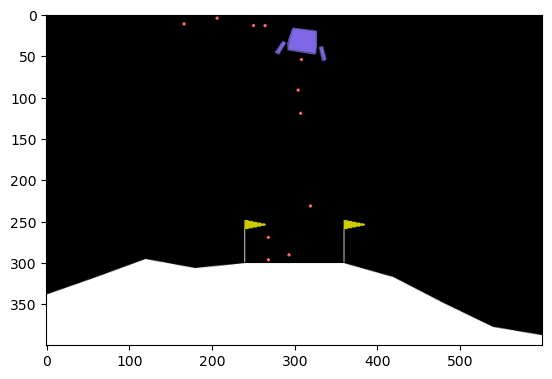

In [17]:
for _ in range(7):
    env.step(3)
    env.step(2)
plt.imshow(env.render())

-   0 : 아무행동도 하지 않음
-   1 : 왼쪽
-   2 : 위
-   3 : 오른쪽

# 5. 시각화

In [18]:
def show(ims,jump=10):
    ims = ims[::jump]
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
        ax.imshow(ims[i])
    ani = FuncAnimation(fig,update,frames=len(ims))
    display(IPython.display.HTML(ani.to_jshtml()))

In [19]:
current_state, _ = env.reset()
ims = [] 
for t in range(500): 
    action = env.action_space.sample()
    next_state, reward, terminated, _, _ = env.step(action)
    im = env.render()
    ims.append(im) 
    current_state = next_state 
    if terminated: break 

In [20]:
show(ims) 

# 6. `q_net`

`-` 원래는 `agent.q` 에 해당하는 것인데, 이전에서는 `agent.q`를 (4,4,4)
shape의 numpy array 를 사용했는데 여기서는 불가능

-   4x4 grid: 상태공간의 차원은 2차원이며 가질수 있는 값은 16개, 각
    상태공간에서 할수 있는 행동이 4개 -\> 총 16\*4의 경우의 수에 대한
    reward만 조사하면 되었음
-   LunarLander: 상태공간의 차원은 8차원이지만 가질수 있는 값의 범위는
    무한대 -\> 무수히 많은 경우에 대한 reward 값을 조사하는건 현실적으로
    불가능

`-` 데이터를 모아보자.

In [21]:
current_states = collections.deque(maxlen=50) 
actions = collections.deque(maxlen=50) 
next_states = collections.deque(maxlen=50) 
rewards = collections.deque(maxlen=50) 
terminations = collections.deque(maxlen=50) 

current_state, _ = env.reset()
for t in range(500): 
    ## step1: agent >> env 
    action = env.action_space.sample()
    ## step2:agent << env 
    next_state, reward, terminated, _, _ = env.step(action)
    current_states.append(current_state)
    actions.append(action)
    next_states.append(next_state)
    rewards.append(reward)
    terminations.append(terminated) 
    ## step3: learn 
    ## step4: update state     
    current_state = next_state 
    ## step5: 종료조건체크 
    if terminated: break 

`-` 이전코드에서 아래에 대응하는 부분을 구현하면 된다.

``` python
## 1. q[x,y,a]를 초기화: q(s)를 넣으면 action에 대한 q값을 알려주는 기능 
agent.q = np.zeros([4,4,4]) 

## 2. q_estimated 를 계산 
x,y = agent.current_state
xx,yy = agent.next_state
a = agent.action 
q_estimated = agent.q[x,y,a] 

## 3. q_realistic = agent.reward + 0.99 * q_future 를 수행하는 과정 
if agent.terminated:
    q_realistic = agent.reward
else:
    q_future = q[xx,yy,:].max()
    q_realistic = agent.reward + 0.99 * q_future

## 4. q_estimated 를 점점 q_realistic 와 비슷하게 만드는 과정 
diff = q_realistic - q_estimated 
agent.q[x,y,a] = q_estimated + 0.05 * diff 
```

`1`. agent.q 에 대응하는 과정

In [22]:
q_net = torch.nn.Sequential(
    torch.nn.Linear(8,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,4)
)

In [23]:
q_net # <- 8개의 숫자가 입력으로 오면 4개의 숫자를 리턴하는 함수 

In [24]:
q_net(torch.tensor(current_state))

-   q_net은 8개의 숫자가 입력으로 오면 4개의 숫자가 리턴되는 함수이다.
-   해석을 하면 8개의 숫자는 state를 나타내는 숫자로 이해할 수 있고
    4개의 숫자는 각 action에 대한 q값으로 해석할 수 있다.
-   하지만 이 숫자가 합리적인건 아님 (아무숫자임)
-   q_net의 특징: 고정된 함수가 아니고 데이터를 이용하여 점점 더
    그럴듯한 숫자를 뱉어내도록 학습할 수 있는 함수이다. (뉴럴네트워크)

`1`. agent.q 에 대응하는 과정 (배치버전)

– get batch –

In [25]:
batch_size = 4 
idx = np.random.randint(0,50,size=batch_size)

current_states_batch = torch.tensor(np.array(current_states))[idx].float()
actions_batch = torch.tensor(np.array(actions))[idx].reshape(batch_size,-1) 
rewards_batch = torch.tensor(np.array(rewards))[idx].reshape(batch_size,-1).float()
next_states_batch = torch.tensor(np.array(next_states))[idx].float()
terminations_batch = torch.tensor(np.array(terminations))[idx].reshape(batch_size,-1)

– q_net –

In [26]:
current_states_batch

In [27]:
q_net(current_states_batch)

`2`. q_estimated

In [28]:
q_net(current_states_batch), actions_batch

In [29]:
q_net(current_states_batch).gather(1,actions_batch)

`3`. q_realistic = agent.reward + 0.99 \* q_future

– q_future –

In [30]:
q_future = q_net(next_states_batch).max(axis=1)[0].reshape(batch_size,1)
q_future

In [31]:
q_realistic = rewards_batch + 0.99 * q_future * (~terminations_batch)

`4`. q_estimated 를 점점 q_realistic 와 비슷하게 만드는 과정

``` python
## 여기는.. 딥러닝과 파이토치를 좀 알아야.. 모른다면 일단 패스해야합니다.. 
optimizer = torch.optim.Adam(q_net.parameters(),lr=0.0001) 
for _ in range(2000):
    ~~~
    ~~~
    q_estimated = ~~~ 
    q_realistic = ~~~ 
    loss = torch.nn.functional.mse_loss(q_estimated,q_realistic)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
```

# 7. Policy

In [32]:
eps = 0.5 
if np.random.rand() < eps:
    action = env.action_space.sample() 
else:
    action = q_net(torch.tensor(current_state)).argmax().item()

In [33]:
action

# 8. Agent 클래스 + run

In [64]:
class Agent():
    def __init__(self,env):
        self.eps = 0
        self.n_experiences = 0
        self.n_episode = 0
        self.score = 0
        self.scores = []
        self.playtimes = []
        self.batch_size = 128
        self.buffer_size = 50000
        self.action_space = env.action_space
        #self.state_space = env.observation_space

        # Q-Network
        self.q_net = torch.nn.Sequential(
            torch.nn.Linear(8,128), 
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,4)
        )
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=0.0001)

        # ReplayBuffer
        self.current_states = collections.deque(maxlen=self.buffer_size)
        self.actions = collections.deque(maxlen=self.buffer_size)
        self.rewards = collections.deque(maxlen=self.buffer_size)
        self.next_states = collections.deque(maxlen=self.buffer_size)
        self.terminations = collections.deque(maxlen=self.buffer_size)
       
    def save_experience(self):
        """Add a new experience to memory."""
        self.current_states.append(self.current_state)
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(self.next_state)
        self.terminations.append(self.terminated) 
        self.n_experiences = self.n_experiences+1
        self.score += self.reward
    
    def act(self):
        if np.random.rand() < self.eps:
            self.action = self.action_space.sample()
        else:
            self.action = self.q_net(torch.tensor(self.current_state)).argmax().item()
            
    def get_batch(self):
        idx = np.random.randint(0,self.buffer_size,size=self.batch_size) 
        self.current_states_batch = torch.tensor(np.array(self.current_states))[idx].float()
        self.actions_batch = torch.tensor(np.array(self.actions))[idx].reshape(self.batch_size,1)
        self.rewards_batch = torch.tensor(np.array(self.rewards))[idx].reshape(self.batch_size,-1).float()
        self.next_states_batch = torch.tensor(np.array(self.next_states))[idx].float()
        self.terminations_batch = torch.tensor(np.array(self.terminations))[idx].reshape(self.batch_size,-1) 
    
    def learn(self):
        if self.n_experiences < self.buffer_size:
            pass
        else: 
            self.get_batch()
            q_estimated = self.q_net(self.current_states_batch).gather(1, self.actions_batch)
            q_future = self.q_net(self.next_states_batch).detach().max(1)[0].reshape(self.batch_size,1)
            q_realistic = self.rewards_batch + 0.99 * q_future * (~self.terminations_batch)

            loss = torch.nn.functional.mse_loss(q_estimated, q_realistic)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

In [35]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')
agent = Agent(env)
agent.eps = 1.0 
for _ in range(2000):
    ### 1. 본질적인 코드
    agent.current_state, _  = env.reset() 
    agent.terminated = False
    agent.score = 0 
    for t in range(500):
        # step1: agent >> env 
        agent.act() 
        env.agent_action = agent.action  
        # step2: agent << env 
        agent.next_state, agent.reward, agent.terminated, _,_ = env.step(env.agent_action)
        agent.save_experience() 
        # step3: learn 
        agent.learn()
        # step4: state update 
        agent.current_state = agent.next_state 
        # step5: 
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t+1)
    agent.n_episode = agent.n_episode + 1 
    agent.eps = agent.eps*0.995
    ## 2. 비본질적 코드
    if (agent.n_episode % 10) == 0:
        print(
            f'Episode {agent.n_episode}\t'
            f'Score: {np.mean(agent.scores[-100:]) : .2f}\t'
            f'Playtime: {np.mean(agent.playtimes[-100:]) : .2f}\t'
            f'n_eps: {agent.eps}\t'
            f'n_experiences: {agent.n_experiences}\t'
        )
    if np.mean(agent.scores[-100:])>=200.0:
        break

Episode 10  Score: -203.26  Playtime:  95.50    n_eps: 0.9511101304657719   n_experiences: 955  
Episode 20  Score: -208.47  Playtime:  99.00    n_eps: 0.9046104802746175   n_experiences: 1980 
Episode 30  Score: -229.49  Playtime:  103.27   n_eps: 0.8603841919146962   n_experiences: 3098 
Episode 40  Score: -239.50  Playtime:  105.42   n_eps: 0.8183201210226743   n_experiences: 4217 
Episode 50  Score: -237.79  Playtime:  105.02   n_eps: 0.778312557068642    n_experiences: 5251 
Episode 60  Score: -250.40  Playtime:  109.72   n_eps: 0.7402609576967045   n_experiences: 6583 
Episode 70  Score: -252.73  Playtime:  111.06   n_eps: 0.7040696960536299   n_experiences: 7774 
Episode 80  Score: -256.20  Playtime:  114.19   n_eps: 0.6696478204705644   n_experiences: 9135 
Episode 90  Score: -266.69  Playtime:  116.46   n_eps: 0.6369088258938781   n_experiences: 10481    
Episode 100 Score: -275.97  Playtime:  118.12   n_eps: 0.6057704364907278   n_experiences: 11812    
Episode 110 Score: -29

`-` 시각화를 위한코드

In [50]:
agent2 = Agent(env) 
agent2.q_net = agent.q_net

agent2.current_state, _ = env.reset()
agent2.terminated = False 
ims = [] 
ims.append(env.render())
for t in range(500):
    agent2.act() 
    agent2.next_state, agent2.reward, agent2.terminated, _, _  = env.step(agent2.action)
    im = env.render()
    ims.append(im)
    agent2.current_state = agent2.next_state
    if agent2.terminated: break 

In [51]:
show(ims)